In [159]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler 
from collections import Counter

### Data Preparation and Cleaning
- Admittedly, this is not the most efficient code. But it gets the job done.

In [2]:
#Read in dataframe
df = pd.read_csv("data_train.csv")

In [3]:
#DATA CLEANING STEPS

#Steps to clean data by dropping columns where the number of empty rows is >= 445,000
dfComplete = df.dropna(1, thresh= 445000)
# dfComplete.shape #Results in (494932,58)

#Steps to clean data by dropping row where the number of empty columns is > 0
dfCompleteAll = dfComplete.dropna(0, how="any")
# dfCompleteAll.shape #results in a dataframe of (476155,58)

# dfCompleteAll.isnull().sum() #no more nulls in the dataset

In [4]:
#Extract Dataframe of Variables for Classification
y = dfCompleteAll[["ASOURCE", "ATYPE", "RACE", "TOTCHG", "ZIPINC_QRTL"]]
y.head()

,ASOURCE,ATYPE,RACE,TOTCHG,ZIPINC_QRTL
0,2,2,1,272123,3
1,2,2,1,209246,1
2,2,2,1,305474,1
3,2,2,1,202973,1
4,2,2,1,416072,1


In [5]:
"""The next step is to prepare variables for exploratory data analysis and feature
selection using a random forest. 

Random forest does not require standardization of continuous variables or normalization
of discrete variable. For categorical features, we will need to use pd.get_dummies or 
one hot encoding to create binary dummy variables. 
"""

#First create two dataframes of int and float values to make things easier to work with 
columnNames = dfCompleteAll.columns
dfFloat = pd.DataFrame()
dfInt = pd.DataFrame()
for name in columnNames:
    if dfCompleteAll[name].dtype == float:
        dfFloat = dfFloat.join(dfCompleteAll[name], how = "right")
    else:
        dfInt = dfInt.join(dfCompleteAll[name], how = "right")
        
#Convert all columns in DfFloat, except DISCWT, to integer values. Afterwards nominal features
#will be one-hot encoded to create dummy variables, again we will not normalize or stadardize
# numeric values. 

float_toInt = ['AGE', 'AMONTH', 'AWEEKEND', 'DIED', 'DISPUNIFORM', 'DXCCS1',
       'DXCCS2', 'FEMALE', 'LOS', 'PAY1', 'HOSP_BEDSIZE', 'HOSP_CONTROL',
       'HOSP_LOCTEACH']
for digit in float_toInt:
    dfFloat[digit] = dfFloat[digit].astype(int)

In [6]:
# In dfFloat we have the following columns and feature groupings. 
# For reference use feature_desc or call .unique() method on one of the columns

# CONTINUOUS:
dfFloatContinuous = dfFloat[["AGE", "DISCWT"]]


# NOMINAL:
dfFloatNominal = dfFloat[['AMONTH', 'DISPUNIFORM', 'DXCCS1',
       'DXCCS2', 'PAY1', 'HOSP_CONTROL','HOSP_LOCTEACH']]

# BINARY & ORDINAL
dfBinaryOrdinal = dfFloat[["DIED", "AWEEKEND", "FEMALE", "HOSP_BEDSIZE"]]

# DISCRETE
dfDiscrete = dfFloat[["LOS"]]

In [7]:
#Use pd.get_dummies to turn nominal variables into dummy variables by first setting all 
#values as string, a requirement of pd.get_dummies. 

dfFloatNominal = dfFloatNominal.loc[:].astype(str)
    
dfFloatNominal = pd.get_dummies(dfFloatNominal)
dfFloatNominal.shape 

(475155, 556)

In [8]:
#Normally here, we might turn values in dfFloatContinuous to normalized, however,
#DTs and RFs do not require this. Later if we use a different classifier, we will need
# to standardize or normalize. 

#Normalization: rescaling features to a range of [0, 1], a special case of min-max scaling.

#Standardization: Often more practical, center the feature columns at mean 0 with 
# standard deviation 1 so that the feature columns take the form of a normal distribution, 
#This make it easier to learn the weights.

In [9]:
# We can now recreate the original dfFloat dataframe as dfFloatPreprocessed which 
# will have variables ready for feature selection with RF. Next the same thing must be down
#with dfInt
list_of_dataframes = [dfFloatContinuous, dfBinaryOrdinal, dfDiscrete, dfFloatNominal]

dfFloatPreprocessed = pd.DataFrame()
for frame in list_of_dataframes:
    dfFloatPreprocessed = dfFloatPreprocessed.join(frame, how = "right")
dfFloatPreprocessed.shape

(475155, 563)

In [10]:
#Prepare dfInt for preprocessing, starting with dropping respone variables
dfInt = dfInt.drop(["ASOURCE", "ATYPE", "RACE", "TOTCHG", "ZIPINC_QRTL"], axis= 1)
'''
Uncomment the code below to look at values in each column to see what needs to be dropped 
'''

# columnNamesInt = dfInt.columns

# for name in columnNamesInt:
#     print(name, dfInt[name].unique()) #Any values where 0,1 or ordinal e.g., DQTR we are good

'\nUncomment the code below to look at values in each column to see what needs to be dropped \n'

In [11]:
#CMs are all binary, therefore, create a separate dataframe for these columns: 
dfCm = dfInt[['CM_AIDS', 'CM_ALCOHOL', 'CM_ANEMDEF',
       'CM_ARTH', 'CM_BLDLOSS', 'CM_CHF', 'CM_CHRNLUNG', 'CM_COAG',
       'CM_DEPRESS', 'CM_DM', 'CM_DMCX', 'CM_DRUG', 'CM_HTN_C', 'CM_HYPOTHY',
       'CM_LIVER', 'CM_LYMPH', 'CM_LYTES', 'CM_METS', 'CM_NEURO', 'CM_OBESE',
       'CM_PARA', 'CM_PERIVASC', 'CM_PSYCH', 'CM_PULMCIRC', 'CM_RENLFAIL',
       'CM_TUMOR', 'CM_ULCER', 'CM_VALVE', 'CM_WGHTLOSS']]

#Update the dfInt dataframe to a new dataframe:
dfIntShort = dfInt.drop(['CM_AIDS', 'CM_ALCOHOL', 'CM_ANEMDEF',
       'CM_ARTH', 'CM_BLDLOSS', 'CM_CHF', 'CM_CHRNLUNG', 'CM_COAG',
       'CM_DEPRESS', 'CM_DM', 'CM_DMCX', 'CM_DRUG', 'CM_HTN_C', 'CM_HYPOTHY',
       'CM_LIVER', 'CM_LYMPH', 'CM_LYTES', 'CM_METS', 'CM_NEURO', 'CM_OBESE',
       'CM_PARA', 'CM_PERIVASC', 'CM_PSYCH', 'CM_PULMCIRC', 'CM_RENLFAIL',
       'CM_TUMOR', 'CM_ULCER', 'CM_VALVE', 'CM_WGHTLOSS'],axis = 1)

# columnNamesInt = dfIntShort.columns
# for name in columnNamesInt:
#     print(name, dfIntShort[name].unique()) #Any values where 0,1 or ordinal e.g., DQTR we are good

In [12]:
#Continue evaluating values in each column

#Since NDX, NPR, ORPROC, TOTAL_DISC are all either Binary or Discerete variables, create a separate dataframe
dfIntBinaryDiscrete = dfIntShort[["NDX", "NPR", "ORPROC", "TOTAL_DISC"]]

# Since DQTR, HOSPID, MDC, NIS_STRATUM, HOSP_REGION are all nominal variables, create a separate dataframe to 
#turn these into dummy variables. ALSO Drop "KEY" as this is the record id field: 
dfIntToDummies = dfIntShort.drop(["KEY", "NDX", "NPR", "ORPROC", "TOTAL_DISC"], axis= 1)


In [13]:
#Turn values in DQTR, HOSPID, MDC, NIS_STRATUM, HOSP_REGION to string
dfIntToDummies = dfIntToDummies.loc[:].astype(str)

#Use pd.get_dummies to turn nominal string values to binary dummy variables
dfIntToDummies = pd.get_dummies(dfIntToDummies)
# dfIntToDummies.head()

In [14]:
#Recombinet the three dataframes into a new preprocessed dataframe called dfIntPreprocessed
intRecombine = [dfIntToDummies, dfCm, dfIntBinaryDiscrete]

dfIntPreprocessed = pd.DataFrame()
for df in intRecombine:
    dfIntPreprocessed = dfIntPreprocessed.join(df, how = "right")
    
# dfIntPreprocessed.shape

In [15]:
#Combine the now preprocessed dfInt and dfFloat dataframes back in a single dataframe of either discrete, continuous,
#or binary variables. 
dfPreprocessed = dfFloatPreprocessed.join(dfIntPreprocessed, how = "right")
arrayPreprocessed = np.array(dfPreprocessed)
dfPreprocessed.head() #these are our predictors

,AGE,DISCWT,DIED,AWEEKEND,FEMALE,HOSP_BEDSIZE,LOS,AMONTH_1,AMONTH_10,AMONTH_11,...,CM_PULMCIRC,CM_RENLFAIL,CM_TUMOR,CM_ULCER,CM_VALVE,CM_WGHTLOSS,NDX,NPR,ORPROC,TOTAL_DISC
0,48,4.671227,0,0,0,1,83,0,0,1,...,0,0,0,0,0,1,18,7,1,409
1,66,4.671227,0,0,0,1,50,0,0,1,...,0,0,0,0,0,1,18,8,0,409
2,53,4.671227,0,0,0,1,65,0,0,1,...,0,0,0,0,0,1,18,6,0,409
3,27,4.671227,0,0,1,1,59,0,0,1,...,0,0,0,0,0,1,18,4,0,409
4,48,4.671227,1,0,0,1,77,0,0,1,...,1,1,0,0,0,1,18,8,0,409


## Exploratory Data Analysis

1    326960
2     83746
3     38750
6     18408
4      6561
5       730
Name: RACE, dtype: int64

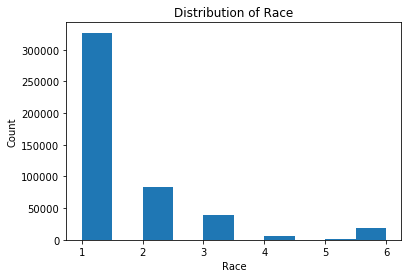

In [16]:
#Look at distribution of Race
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(y["RACE"], histtype="bar")
plt.title("Distribution of Race")
plt.ylabel("Count")
plt.xlabel("Race")

y.RACE.value_counts()

5    322233
1    121396
2     17097
3     14312
4       117
Name: ASOURCE, dtype: int64

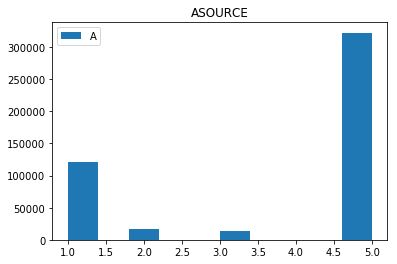

In [17]:
#Look at ASOURCE
plt.hist(y["ASOURCE"],histtype="bar",)
plt.title("ASOURCE")
plt.legend("ASOURCE")

y.ASOURCE.value_counts()

1    255366
3    106770
2     87084
4     24558
6       705
5       672
Name: ATYPE, dtype: int64

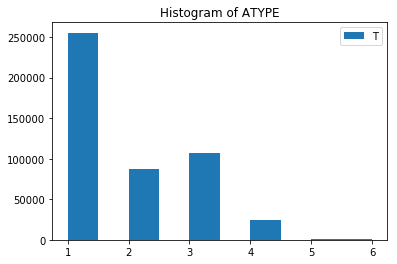

In [18]:
#Look at ATYPE
plt.hist(y["ATYPE"])
plt.title("Histogram of ATYPE")
plt.legend("TYPE")

y.ATYPE.value_counts()

count    4.751550e+05
mean     2.315819e+04
std      3.868960e+04
min      1.010000e+02
25%      6.286000e+03
50%      1.233700e+04
75%      2.570800e+04
max      1.461234e+06
Name: TOTCHG, dtype: float64

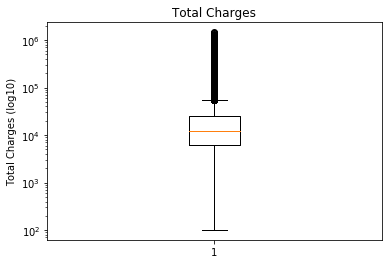

In [19]:
#Box plot for total charges --> Will need to create bins for this response variable
plt.boxplot(y["TOTCHG"])
plt.yscale('log')
plt.title("Total Charges")
plt.ylabel("Total Charges (log10)")
y["TOTCHG"].describe()

4    158690
1    122884
3    109733
2     83848
Name: ZIPINC_QRTL, dtype: int64

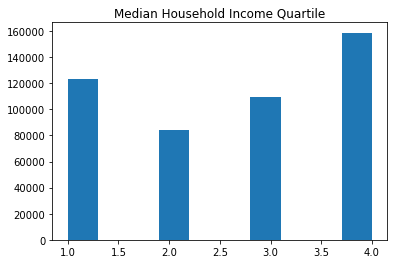

In [20]:
#HIST for ZIPINC_QRTL - Median Household incoe, national quartile for patient zip code
plt.hist(y["ZIPINC_QRTL"])
plt.title("Median Household Income Quartile")
y["ZIPINC_QRTL"].describe()

y.ZIPINC_QRTL.value_counts()

## Random Forest on Undersample Data
- Imbalanced class distributions present a big challenge for our classifier. From experience (we tried random forests on un-resampled data), we know we'll need to resample our data for better predictive power.

In [24]:
#before we do anything, we need to plug our DFs back together so other features can help predict race.
dfFull = pd.concat([dfPreprocessed, y], axis=1)

X_race = dfFull.drop(['RACE'], axis=1) #all columns except race
y_race = dfFull.RACE #RACE column

#CRUCIALLY, must do a train test split before any resampling; we HAVE to hold out observed test data
X_train_race, X_test_race, y_train_race, y_test_race = train_test_split(X_race, y_race, test_size = 0.25,
                                                                       random_state = 12)

In [25]:
y_train_race.value_counts()

1    245078
2     62863
3     29118
6     13824
4      4933
5       550
Name: RACE, dtype: int64

In [27]:
y_train_race.value_counts(normalize=True)

1    0.687714
2    0.176400
3    0.081708
6    0.038792
4    0.013843
5    0.001543
Name: RACE, dtype: float64

In [28]:
len(y_train_race)

356366

No wonder a random forest on the base data won't classify anything in the 4 and 5 classes.

In [29]:
#we pass a dict with desired values to the random under sampler object. Admittedly, our values are a bit arbitrary
rus = RandomUnderSampler(ratio = {1:50000, 2:20000, 3:15000, 4:4933, 5:550, 6:13824}, random_state=12) 

#this time, ratio = auto means resample all except minority class
uX_train_race, uy_train_race = rus.fit_sample(X_train_race, y_train_race)

In [36]:
#new counts
new_race_counts = pd.Series(uy_train_race)
new_race_counts.value_counts(normalize=True)

1    0.479354
2    0.191742
3    0.143806
6    0.132532
4    0.047293
5    0.005273
dtype: float64

In [37]:
len(uy_train_race)

104307

### "Base" Random Forest on this data:
- We'll cross validate shortly, but first we want to see "base" performance.
- In reality, we ran a few random forests to start zeroing in on what ideal settings might be. 
    - Interestingly, using a large number of estimators gets better results (this may be because the high proportion of "dummy" variables - many predictors are just long arrays of mainly zeroes).

In [38]:
#these are pretty high variance settings to start
rus_clf = RandomForestClassifier(n_jobs=-1,max_features='auto',n_estimators=300,max_depth=250,min_samples_split=2,
                             min_samples_leaf=1,oob_score = True, random_state=12)

rus_clf.fit(uX_train_race, uy_train_race)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=250, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=True, random_state=12, verbose=0, warm_start=False)

In [39]:
rus_model_predictions = rus_clf.predict(X_test_race)
rus_model_accuracy = accuracy_score(y_test_race, rus_model_predictions)
rus_model_accuracy

0.75904334576433841

In [41]:
rus_model_report = classification_report(y_test_race, rus_model_predictions)
print(rus_model_report)

             precision    recall  f1-score   support

          1       0.85      0.90      0.88     81882
          2       0.59      0.45      0.51     20883
          3       0.47      0.50      0.49      9632
          4       0.13      0.06      0.08      1628
          5       0.12      0.01      0.01       180
          6       0.37      0.40      0.38      4584

avg / total       0.75      0.76      0.75    118789



In [42]:
pd.crosstab(y_test_race, rus_model_predictions, rownames=['Actual Race'], colnames=['Predicted Race'])

Predicted Race,1,2,3,4,5,6
Actual Race,,,,,,
1,73927,4410,1755,315,1,1474
2,7324,9473,2956,167,1,962
3,3030,1159,4843,83,2,515
4,948,270,144,96,2,168
5,136,10,28,1,1,4
6,1441,659,573,84,1,1826


### Cross-Validation with Grid Search CV:
- Let's see if we can run a grid search without nuking my RAM. 
- Note that we aren't going to cross val number of trees. We know that, up to a point, the model should get better with more trees. So we'll keep trees modest to improve run time. **Then we can always ramp up trees on a single run with other parameters optimized.**

In [50]:
#try even smaller values for a resample; otherwise cross val won't run
#these could potentially bias our estimator (more than we intend to); we should run predictions with best params
#but also pass these best params to a single RF that runs on the larger data, and see what does best

small_rus = RandomUnderSampler(ratio = {1:10000, 2:6000, 3:3500, 4:2000, 5:550, 6:3000}, random_state=12) 

#this time, ratio = auto means resample all except minority class
uRXtr_slice, uRytr_slice = small_rus.fit_sample(X_train_race, y_train_race)

In [80]:
undersample_slice = pd.Series(uRytr_slice)
undersample_slice.value_counts(normalize=True)

1    0.399202
2    0.239521
3    0.139721
6    0.119760
4    0.079840
5    0.021956
dtype: float64

In [51]:
param_grid = {
    'min_samples_split': [2, 3, 5, 10],
    'max_features': ['auto', 100, 300]
}

#auto features = sqrt = ~28

#keep cv arg at default (3) - more small classes for test?
CV_model = GridSearchCV(estimator=rus_clf, param_grid=param_grid, scoring='f1_micro', n_jobs=-1,
                        return_train_score=False)

CV_model.fit(uRXtr_slice, uRytr_slice)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=250, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=True, random_state=12, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_samples_split': [2, 3, 5, 10], 'max_features': ['auto', 100, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='f1_micro', verbose=0)

In [52]:
CV_model.best_params_

{'max_features': 100, 'min_samples_split': 5}

In [53]:
CV_model_predictions = CV_model.predict(X_test_race)
CV_model_accuracy = accuracy_score(y_test_race, CV_model_predictions)
CV_model_accuracy

0.72829975839513761

In [55]:
CV_model_report = classification_report(y_test_race, CV_model_predictions)
print(CV_model_report)

             precision    recall  f1-score   support

          1       0.87      0.83      0.85     81882
          2       0.50      0.56      0.53     20883
          3       0.45      0.48      0.47      9632
          4       0.10      0.15      0.12      1628
          5       0.06      0.07      0.07       180
          6       0.39      0.36      0.38      4584

avg / total       0.74      0.73      0.73    118789



In [57]:
pd.crosstab(y_test_race, CV_model_predictions, rownames=['Actual Race'], colnames=['Predicted Race'])

Predicted Race,1,2,3,4,5,6
Actual Race,,,,,,
1,68214,8651,2288,1236,129,1364
2,5260,11727,2695,508,21,672
3,2512,1820,4655,193,19,433
4,779,360,129,245,2,113
5,107,20,31,7,12,3
6,1253,954,515,195,6,1661


We've taken a knock on overall f-1 score (and overall accuracy), but **our individual f-1 scores for class 4 and 5 are the highest we've been able to return!**

Hard to know whether this is due to model tuning, or the even smaller slice of data.

Let's compare it to a model with these ideal parameters on the "full" (but really, resampled) data:

In [58]:
rus_clf_tuned = RandomForestClassifier(n_jobs=-1,max_features=100,n_estimators=300,max_depth=250,min_samples_split=5,
                             min_samples_leaf=1,oob_score = True, random_state=12)

rus_clf_tuned.fit(uX_train_race, uy_train_race)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=250, max_features=100, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=True, random_state=12, verbose=0, warm_start=False)

In [59]:
rus_clf_tuned_predictions = rus_clf_tuned.predict(X_test_race)
rus_clf_tuned_accuracy = accuracy_score(y_test_race, rus_clf_tuned_predictions)
rus_clf_tuned_accuracy

0.75867294109723959

In [61]:
rus_clf_tuned_report = classification_report(y_test_race, rus_clf_tuned_predictions)
print(rus_clf_tuned_report)

             precision    recall  f1-score   support

          1       0.86      0.89      0.88     81882
          2       0.59      0.47      0.52     20883
          3       0.47      0.53      0.50      9632
          4       0.15      0.07      0.09      1628
          5       1.00      0.01      0.01       180
          6       0.36      0.43      0.39      4584

avg / total       0.75      0.76      0.75    118789



In [62]:
pd.crosstab(y_test_race, rus_clf_tuned_predictions, rownames=['Actual Race'], colnames=['Predicted Race'])

Predicted Race,1,2,3,4,5,6
Actual Race,,,,,,
1,73114,4763,2080,316,0,1609
2,6755,9847,2985,178,0,1118
3,2751,1172,5099,71,0,539
4,915,253,148,112,0,200
5,130,14,32,1,1,2
6,1349,631,583,72,0,1949


**Honestly not sure whether this model is better or worse than our "base" model".** 
- The observed f-1 scores are the same. It almost never predicts class 5 - when it does, exactly once, it nails it! (this is just as likely due to random chance)
- Overall accuracy is a tiny bit lower, but this is probably due to random chance.

### We conclude that model tuning is not really improving our results. To the extent f-1 scores change or improve, it's likely due to data sampling.

In [63]:
#just to be sure, one more model with alot more trees.
rus_tuned_trees = RandomForestClassifier(n_jobs=-1,max_features=100,n_estimators=500,max_depth=250,min_samples_split=5,
                             min_samples_leaf=1,oob_score = True, random_state=12)

rus_tuned_trees.fit(uX_train_race, uy_train_race)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=250, max_features=100, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=True, random_state=12, verbose=0, warm_start=False)

In [64]:
rus_tuned_trees_predictions = rus_tuned_trees.predict(X_test_race)
rus_tuned_trees_accuracy = accuracy_score(y_test_race, rus_tuned_trees_predictions)
rus_tuned_trees_accuracy

0.75903492747644985

In [65]:
rus_tuned_trees_report = classification_report(y_test_race, rus_tuned_trees_predictions)
print(rus_tuned_trees_report)

             precision    recall  f1-score   support

          1       0.86      0.89      0.88     81882
          2       0.59      0.47      0.52     20883
          3       0.47      0.53      0.50      9632
          4       0.16      0.07      0.10      1628
          5       0.50      0.01      0.01       180
          6       0.36      0.42      0.39      4584

avg / total       0.75      0.76      0.75    118789



In [66]:
pd.crosstab(y_test_race, rus_tuned_trees_predictions, rownames=['Actual Race'], colnames=['Predicted Race'])

Predicted Race,1,2,3,4,5,6
Actual Race,,,,,,
1,73153,4767,2060,311,1,1590
2,6759,9846,2988,169,0,1121
3,2741,1166,5106,72,0,547
4,917,256,145,115,0,195
5,132,14,30,1,1,2
6,1356,628,585,71,0,1944


Growing more trees does absolutely nothing here.

### Alter Undersampling Proportions in hopes of increasing Class 4 and Class 5 f-1 Scores:

In [81]:
y_train_race.value_counts()

1    245078
2     62863
3     29118
6     13824
4      4933
5       550
Name: RACE, dtype: int64

In [117]:
#desired proportions (approx)
#1    0.399202
#2    0.239521
#3    0.139721
#6    0.119760
#4    0.079840
#5    0.021956

smallest_class = 550 #we're at the mercy of only having 550 observed class = 5 in training; let's build around that
cOne = int(smallest_class * 15) 
cTwo = int(smallest_class * 13)
cThree = int(smallest_class * 11)
cFour = 4933
cFive = 550
cSix = int(smallest_class * 9)

In [118]:
us_rs = RandomUnderSampler(ratio = {1:cOne, 2:cTwo, 3:cThree, 4:cFour, 5:cFive, 6:cSix}, random_state=12)

#this time, ratio = auto means resample all except minority class
rs_Xtr_r, rs_ytr_r = us_rs.fit_sample(X_train_race, y_train_race)

In [119]:
#old proportions
y_train_race.value_counts(normalize=True)

1    0.687714
2    0.176400
3    0.081708
6    0.038792
4    0.013843
5    0.001543
Name: RACE, dtype: float64

In [120]:
#new proportions
new_resample = pd.Series(rs_ytr_r)
new_resample.value_counts(normalize=True)

1    0.258759
2    0.224257
3    0.189756
6    0.155255
4    0.154722
5    0.017251
dtype: float64

### Random Forest on *new* under-sample, based on Tuned Parameters:
- Skeptical that the tuning really improved the model that much.
- But perhaps 5 samples per leaf and 100 features helps control variance; in essence, it's keeping us from going nuts with overpredicting our small classes in training data so accuracy doesn't fall off a cliff in the test set.

In [121]:
rs_rfc = RandomForestClassifier(n_jobs=-1,max_features=100,n_estimators=300,max_depth=250,min_samples_split=5,
                             min_samples_leaf=1,oob_score = True, random_state=12)

rs_rfc.fit(rs_Xtr_r, rs_ytr_r)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=250, max_features=100, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=True, random_state=12, verbose=0, warm_start=False)

In [122]:
rs_rfc_predictions = rs_rfc.predict(X_test_race)
rs_rfc_accuracy = accuracy_score(y_test_race, rs_rfc_predictions)
rs_rfc_accuracy

0.63962151377652809

In [123]:
rs_rfc_report = classification_report(y_test_race, rs_rfc_predictions)
print(rs_rfc_report)

             precision    recall  f1-score   support

          1       0.91      0.69      0.78     81882
          2       0.48      0.54      0.51     20883
          3       0.37      0.60      0.46      9632
          4       0.07      0.46      0.12      1628
          5       0.09      0.08      0.08       180
          6       0.32      0.41      0.36      4584

avg / total       0.75      0.64      0.68    118789



In [124]:
pd.crosstab(y_test_race, rs_rfc_predictions, rownames=['Actual Race'], colnames=['Predicted Race'])

Predicted Race,1,2,3,4,5,6
Actual Race,,,,,,
1,56302,10328,5413,7271,114,2454
2,3241,11223,3551,1931,9,928
3,1356,1142,5818,801,9,506
4,395,176,168,755,4,130
5,62,24,37,35,14,8
6,794,604,688,624,6,1868


**This model goes too far in our opinion.** We have three recall scores over 50% for the first time, and recall for class 4 is in the 40% range! But its accuracy is worse than guessing 1 every time.

### Our best model so far is the one we cross-validated on a 25k slice of data.
- We feel this strikes the trade off between overall accuracy, overall f-1 scores, and individual f-1 scores.
    - You can get higher overall accuracy by predicting race = 1 more.
    - You can get better average f-1 scores by barely predicting race = 5
    - But this model has our highest individual f-1 scores for race = 4 and race = 5 by sacrificing only .02 in average f-1 score.
- **What good is a model for imputing data if it never imputes certain classes?**

## Optimal Settings - Classification of Variable Race:

small_rus = RandomUnderSampler(ratio = {1:10000, 2:6000, 3:3500, 4:2000, 5:550, 6:3000}, random_state=12) 
uRXtr_slice, uRytr_slice = small_rus.fit_sample(X_train_race, y_train_race)

param_grid = {
    'min_samples_split': [2, 3, 5, 10],
    'max_features': ['auto', 100, 300]
}

CV_model = GridSearchCV(estimator=rus_clf, param_grid=param_grid, scoring='f1_micro', n_jobs=-1,
                        return_train_score=False)

Best params: RandomForestClassifier(n_jobs=-1,max_features=100,n_estimators=300,max_depth=250,min_samples_split=5,
                             min_samples_leaf=1,oob_score = True, random_state=12)

Accuracy: ~72.8%

            precision    recall  f1-score   support

          1       0.87      0.83      0.85     81882
          2       0.50      0.56      0.53     20883
          3       0.45      0.48      0.47      9632
          4       0.10      0.15      0.12      1628
          5       0.06      0.07      0.07       180
          6       0.39      0.36      0.38      4584

    avg / total       0.74      0.73      0.73    118789